In [1]:
import rasterio as rio
import numpy as np
from glob import glob
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq, fftshift
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from scipy.stats import pearsonr
from scipy import interpolate
from os.path import join, basename

In [4]:
from interpolate import grid_interpolate
from rotation_crop import find_best_rotated
from spectrum_analysis import azimuthalAverage

In [5]:
locs = glob(join('/bsuscratch/zacharykeskinen/data/uavsar/images/','*'))
for loc in locs:
    if 'Lowman' in loc:
        print(loc)
        pairs = glob(join(loc, '*'))
        pair = [p for p in pairs if basename(p) != 'tmp'][0]
        images = glob(join(pair, '*'))
        images = [i for i in images if 'unw' in i]
        if images:
            image = images[0]
            with rio.open(image) as src:
                image = src.read(1)
            nan_nonint = np.sum(np.isnan(image))
            image = grid_interpolate(image)
            nan_int = np.sum(np.isnan(image))
            number_filled = nan_nonint - nan_int
            best, angle = find_best_rotated(image)
            plt.imshow(best)
            plt.show()

            if number_filled/best.size < 0.15:
                a = best

/bsuscratch/zacharykeskinen/data/uavsar/images/Lowman, CO


In [8]:
from scipy import ndimage
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D

In [80]:
def azimuthalAverage(image, center=None):
    """
    From: https://www.astrobetter.com/wiki/python_radial_profiles
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fractional pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]
    radial_prof = tbin / nr

    return radial_prof

Text(0.5, 0, 'Cycles per Km')

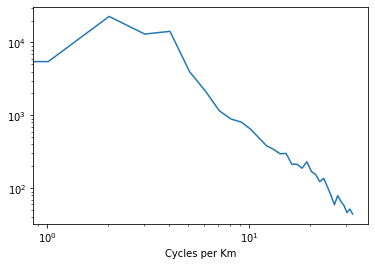

In [102]:
A2d = np.fft.fftshift(np.abs(np.fft.fft2(a))**2)
A1d = azimuthalAverage(A2d)
pixel_spacing = 0.0000555600 #degree/pixel
pixel_spacing = pixel_spacing * 111 # kilometers/ pixel
pixel_spacing = pixel_spacing*10 #resampled
fn = 1/ (pixel_spacing/2)
f = np.linspace(0, fn, A1d.size)
plt.plot(f, A1d)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Cycles per Km')

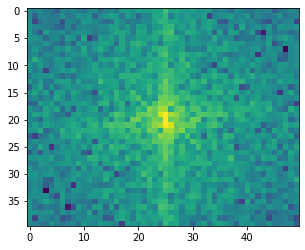

In [103]:
plt.imshow(np.log(A2d))

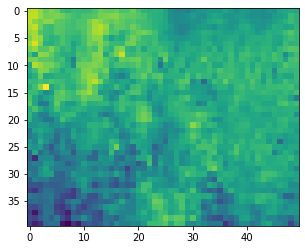

In [104]:
plt.imshow(a)